<a href="https://colab.research.google.com/github/KillShotAK/UoS-Forex-Trading-Robot/blob/main/AllpreprocessMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta
!pip install matplotlib
!pip install scikit-learn
!pip install --upgrade matplotlib
!pip install pandas numpy scikit-learn ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=ba25a43f3d76f301a782be5550729818ec0d935993b6effd756192c34d3a50a7
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

import ta


Label counts for Threshold method:
                 Count  Percentage
Label_Threshold                   
up                6963   42.933777
down              6699   41.305956
hold              2556   15.760266

Label counts for StdDev method:
              Count  Percentage
Label_StdDev                   
up             6076   37.464546
down           5901   36.385498
hold           4241   26.149957

Label counts for Directional method:
                   Count  Percentage
Label_Directional                   
up                  8212   50.635097
down                7901   48.717474
hold                 105    0.647429

Label counts for MA method:
          Count  Percentage
Label_MA                   
up         7026   43.322235
down       6825   42.082871
hold       2367   14.594895

Label counts for PriceChangeDirection method:
                            Count  Percentage
Label_PriceChangeDirection                   
up                           8212   50.635097
down               

<ipython-input-25-87dc3ffb0a35>:85: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 1200x600 with 0 Axes>

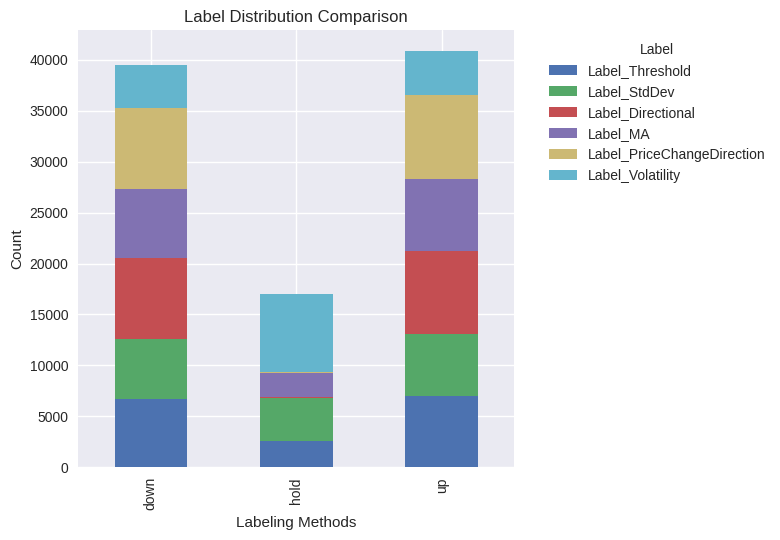

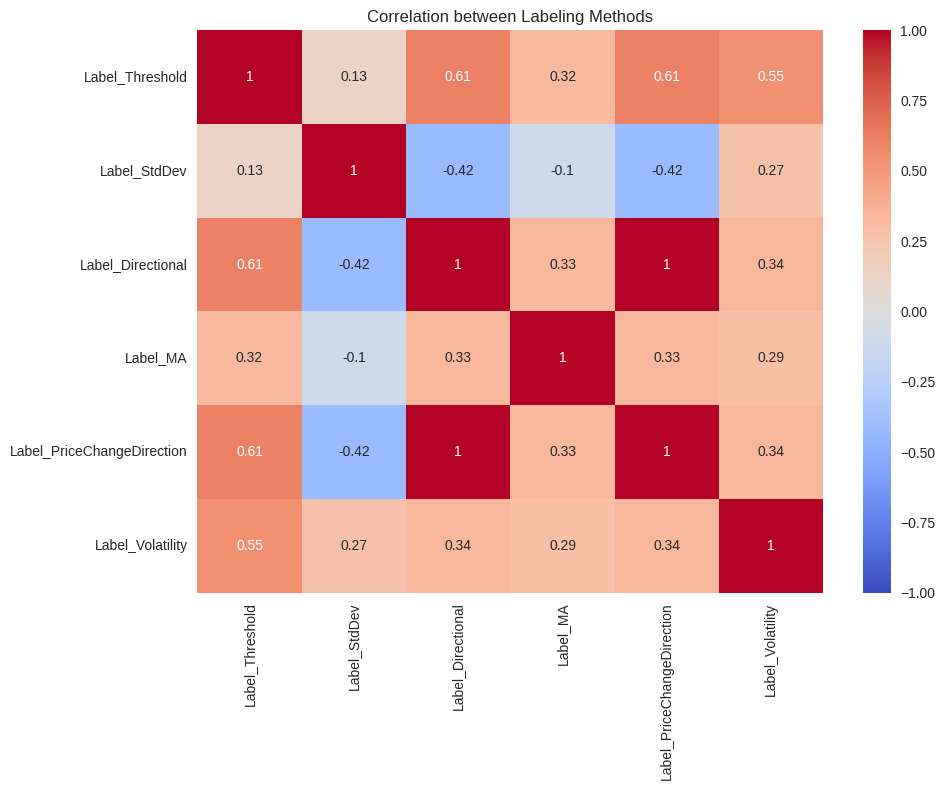

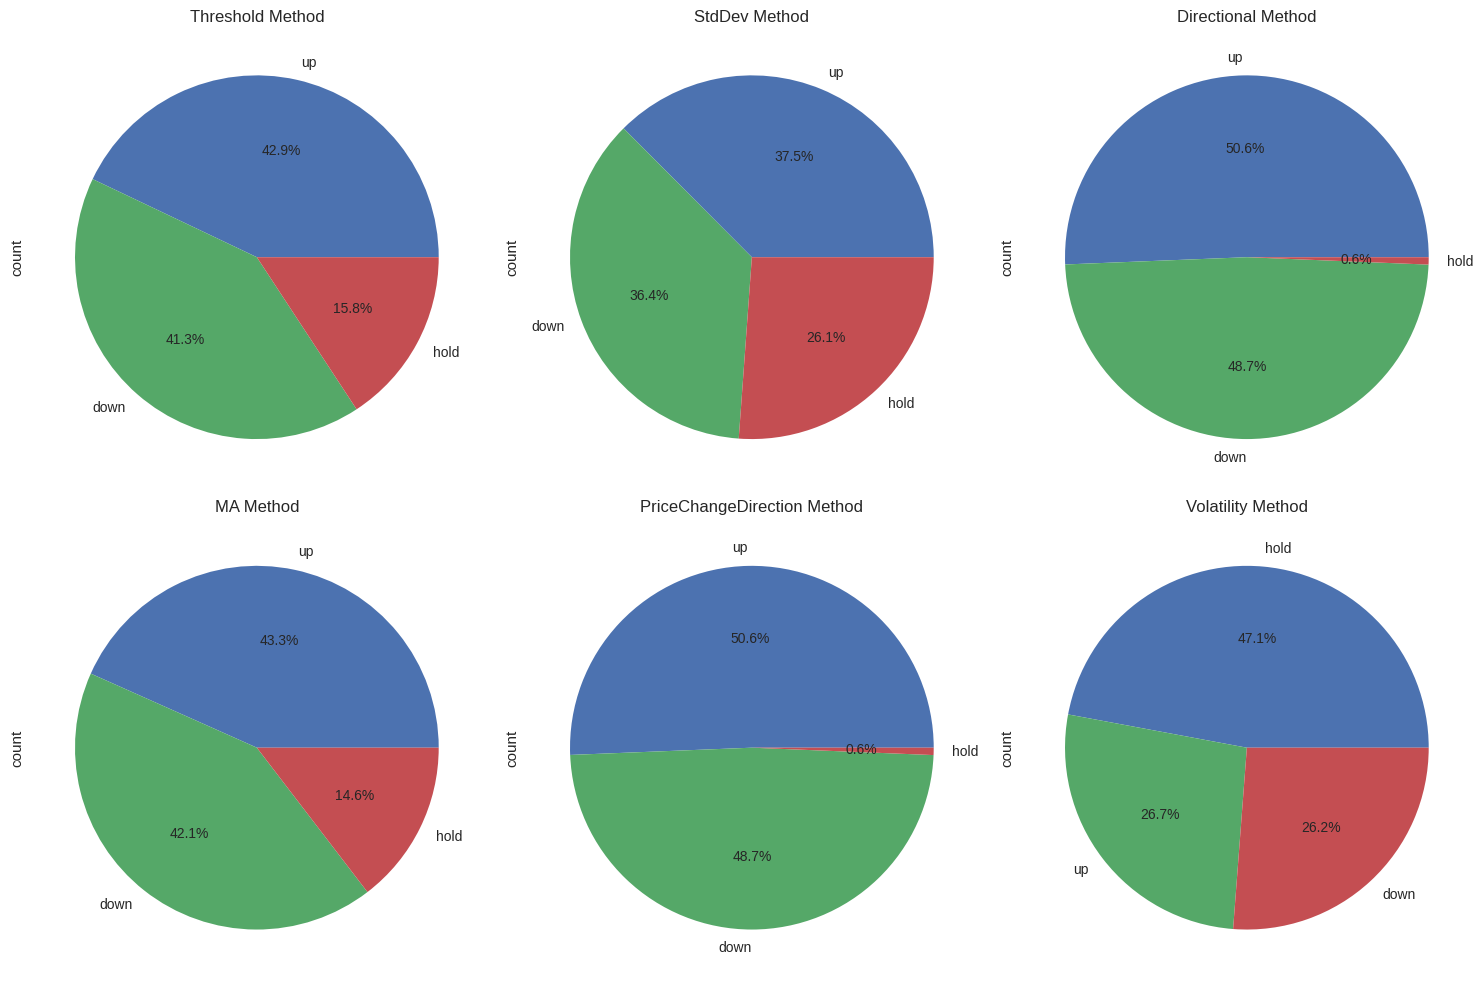

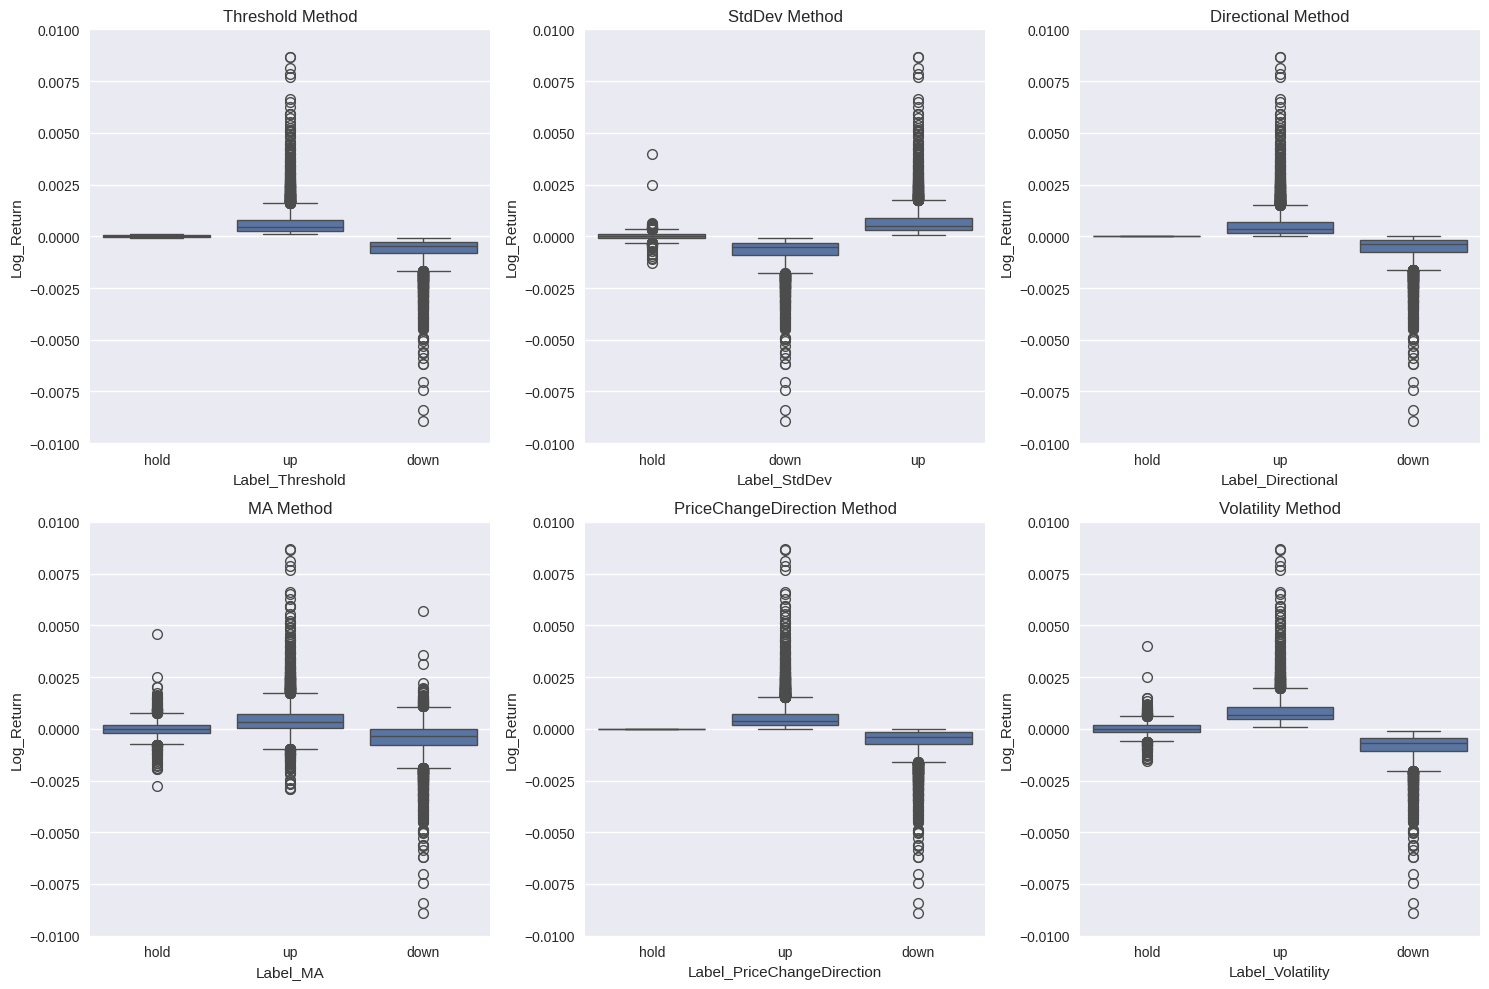

In [ ]:
import pandas as pd
import numpy as np

# Load the dataset from the Excel file
file_path = '/content/EURUSD_prices_Hourly.xlsx'  # Update this with your file path
price_data = pd.read_excel(file_path, engine='openpyxl')

# Calculate log returns
price_data['Log_Return'] = np.log(price_data['Close'] / price_data['Close'].shift(1))

# 1. Adjusted Threshold Method
def label_threshold(log_return, threshold=0.0001):
    if log_return > threshold:
        return "up"
    elif log_return < -threshold:
        return "down"
    else:
        return "hold"

# 2. Adjusted Standard Deviation Method
def label_std_dev(log_returns, window=20, multiplier=0.25):
    rolling_std = log_returns.rolling(window=window).std()
    threshold = multiplier * rolling_std
    return np.where(log_returns > threshold, "up",
                    np.where(log_returns < -threshold, "down", "hold"))

# 3. Directional Method
def label_directional(log_return):
    if log_return > 0:
        return "up"
    elif log_return < 0:
        return "down"
    else:
        return "hold"

# 4. Adjusted Moving Average Method
def label_moving_average(prices, window=5, threshold=0.0001):
    ma = prices.rolling(window=window).mean()
    return np.where(prices > ma * (1 + threshold), "up",
                    np.where(prices < ma * (1 - threshold), "down", "hold"))

# 5. Price Change Direction Method
def label_price_change_direction(df):
    price_change = df['Close'].diff()
    return np.where(price_change > 0, "up",
                    np.where(price_change < 0, "down", "hold"))

# 6. Volatility-Adjusted Method
def label_movement_volatility(log_returns, window=20, multiplier=0.5):
    rolling_std = log_returns.rolling(window=window).std()
    threshold = multiplier * rolling_std
    return np.where(log_returns > threshold, "up",
                    np.where(log_returns < -threshold, "down", "hold"))

# Apply all methods
price_data['Label_Threshold'] = price_data['Log_Return'].apply(label_threshold)
price_data['Label_StdDev'] = label_std_dev(price_data['Log_Return'])
price_data['Label_Directional'] = price_data['Log_Return'].apply(label_directional)
price_data['Label_MA'] = label_moving_average(price_data['Close'])
price_data['Label_PriceChangeDirection'] = label_price_change_direction(price_data)
price_data['Label_Volatility'] = label_movement_volatility(price_data['Log_Return'])

# Display results for each method
methods = ['Threshold', 'StdDev', 'Directional', 'MA', 'PriceChangeDirection', 'Volatility']
for method in methods:
    print(f"\nLabel counts for {method} method:")
    counts = price_data[f'Label_{method}'].value_counts()
    percentages = price_data[f'Label_{method}'].value_counts(normalize=True) * 100
    result = pd.concat([counts, percentages], axis=1, keys=['Count', 'Percentage'])
    print(result)

# Optional: Display first few rows to verify
print("\nFirst few rows of the dataset:")
print(price_data[['Close', 'Log_Return'] + [f'Label_{m}' for m in methods]].head())

# Calculate correlations between different labeling methods
correlation_matrix = price_data[[f'Label_{m}' for m in methods]].apply(lambda x: pd.factorize(x)[0]).corr()
print("\nCorrelation matrix between labeling methods:")
print(correlation_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better-looking plots
plt.style.use('seaborn')

# 1. Bar plot for label distribution
plt.figure(figsize=(12, 6))
label_counts = price_data[[f'Label_{m}' for m in methods]].apply(pd.value_counts)
label_counts.plot(kind='bar', stacked=True)
plt.title('Label Distribution Comparison')
plt.xlabel('Labeling Methods')
plt.ylabel('Count')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Labeling Methods')
plt.tight_layout()
plt.show()

# 3. Pie charts for each method
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, method in enumerate(methods):
    ax = axes[i // 3, i % 3]
    price_data[f'Label_{method}'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%')
    ax.set_title(f'{method} Method')
plt.tight_layout()
plt.show()

# 4. Box plot of log returns for each label
plt.figure(figsize=(15, 10))
for i, method in enumerate(methods):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=f'Label_{method}', y='Log_Return', data=price_data)
    plt.title(f'{method} Method')
    plt.ylim(-0.01, 0.01)  # Adjust as needed
plt.tight_layout()
plt.show()